**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 02. LangGraph 기초 다지기

    - **📒[실습]** Clip 05. LangGraph 기본 사용법 - 조건과 반복

## 1. 조건에 따른 반복 처리하기

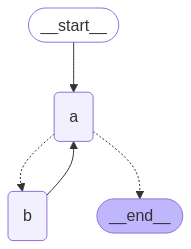

In [1]:
import operator
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]

In [2]:
def a(state: State):
    print(f'Node A 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["B"]}


graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)

In [3]:
def route(state: State):
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


graph_builder.add_edge(START, "a")
graph_builder.add_conditional_edges("a", route)
graph_builder.add_edge("b", "a")
graph = graph_builder.compile()

In [8]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

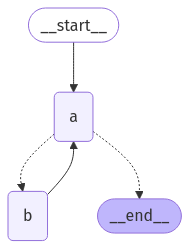

In [9]:
import requests, zlib, base64
from IPython.display import Image

# Mermaid 코드 추출
code = graph.get_graph().draw_mermaid()

# 압축·인코딩 후 Kroki 요청
encoded = base64.urlsafe_b64encode(zlib.compress(code.encode())).decode()
url = f"https://kroki.io/mermaid/png/{encoded}"
resp = requests.get(url)
display(Image(resp.content))

In [10]:
graph.invoke({"aggregate": []})

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node A 처리 중 현재 상태값 : ['A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A']
Node A 처리 중 현재 상태값 : ['A', 'B', 'A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A', 'B', 'A']
Node A 처리 중 현재 상태값 : ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

- GraphRecursionError 로 에러를 반환하는 방법

In [11]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, config={"recursion_limit": 4})
except GraphRecursionError: # 반복 종료 조건에 도달할 수 없는 경우
    print("Recursion Error")

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node A 처리 중 현재 상태값 : ['A', 'B']
Node B 처리 중 현재 상태값 : ['A', 'B', 'A']
Recursion Error


## 2. 조건에 따른 반복 처리하기 (더 복잡한 노드와 엣지 연결)

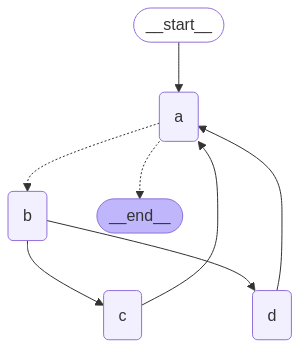

In [12]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]

In [13]:
def a(state: State):
    print(f'Node A 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Node C 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Node D 처리 중 현재 상태값 : {state["aggregate"]}')
    return {"aggregate": ["D"]}


graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)

In [14]:
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


graph_builder.add_edge(START, "a")
graph_builder.add_conditional_edges("a", route)
graph_builder.add_edge("b", "c")
graph_builder.add_edge("b", "d")
graph_builder.add_edge(["c", "d"], "a")
graph = graph_builder.compile()

In [ ]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
result = graph.invoke({"aggregate": []})

Node A 처리 중 현재 상태값 : []
Node B 처리 중 현재 상태값 : ['A']
Node C 처리 중 현재 상태값 : ['A', 'B']
Node D 처리 중 현재 상태값 : ['A', 'B']
Node A 처리 중 현재 상태값 : ['A', 'B', 'C', 'D']
Node B 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A']
Node C 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B']
Node D 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B']
Node A 처리 중 현재 상태값 : ['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']


## 3. 사용자 입력에 따른 반복 조건 설정하기

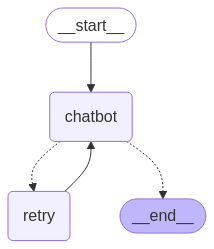

In [18]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    human_messages: Annotated[list[HumanMessage], add_messages]
    ai_messages: Annotated[list[AIMessage], add_messages]
    retry_num : int

In [19]:
def chatbot(state:State):
    retry_num = state["retry_num"]
    user_input = input(f"(현재 {retry_num}번째 답변) 사용자 입력: ")
    ai_message = AIMessage(f"{retry_num}번째 답변중!")

    return {"human_messages": [HumanMessage(content=user_input)], "ai_messages": [ai_message]}

def retry(state: State):
    return {"retry_num" : state["retry_num"] + 1}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("retry", retry)

In [20]:
def route(state: State):
    if "반복" in state["human_messages"][-1].content:
        return "retry"
    else:
        return END


graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", route)
graph_builder.add_edge("retry", "chatbot")
graph = graph_builder.compile()

In [22]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
for chunk in graph.stream({"human_messages" : "반복", "retry_num": 0}, stream_mode="updates"):
    print(chunk)
    for node, value in chunk.items():
        if node:
            print(node)
        if "messages" in value:
            print(value['messages'].content)

{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='73d7cb0c-144e-426c-a47c-46dd26e79f2f')], 'ai_messages': [AIMessage(content='0번째 답변중!', additional_kwargs={}, response_metadata={}, id='5fa5a932-648f-4abd-945b-6b03cddba297')]}}
chatbot
{'retry': {'retry_num': 1}}
retry
{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='eea39d17-d72e-441b-ad7e-6b8d851134ad')], 'ai_messages': [AIMessage(content='1번째 답변중!', additional_kwargs={}, response_metadata={}, id='ce50ed4f-5962-41ba-9b40-d4b5aab0337b')]}}
chatbot
{'retry': {'retry_num': 2}}
retry
{'chatbot': {'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='73ee72b3-dce7-49aa-a8d8-965adc1025ac')], 'ai_messages': [AIMessage(content='2번째 답변중!', additional_kwargs={}, response_metadata={}, id='69759157-bf64-41ce-9bdc-34c94e30daf7')]}}
chatbot
{'retry': {'retry_num': 3}}
retry
{'chatbot': {'human_me

In [26]:
graph.invoke({"human_messages" : "반복", "retry_num": 0})

{'human_messages': [HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='b811fac2-5a78-484a-a2dd-ebad06c02034'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='37f0798b-f29e-4bc2-8f3a-5f06f9e60e33'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='e10b6430-6a16-40d3-b409-1cbfb002cecc'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='dfc8b4f8-c719-40ef-8d20-b71fe1fd655a'),
  HumanMessage(content='반복', additional_kwargs={}, response_metadata={}, id='0ad23a0c-87c6-489e-aa5f-85e149a19f60'),
  HumanMessage(content='그만', additional_kwargs={}, response_metadata={}, id='b18ef2b5-8b5a-4441-9568-19015bf77210')],
 'ai_messages': [AIMessage(content='0번째 답변중!', additional_kwargs={}, response_metadata={}, id='b1e61f19-62a4-4ac1-9ab7-91fedd2aa38e'),
  AIMessage(content='1번째 답변중!', additional_kwargs={}, response_metadata={}, id='275e4a50-7d0b-4a1f-a5e1-8800f87fad39'),
  AIMessage(content='2번째